In [1]:
import numpy as np
from dynesty import NestedSampler
from dynesty import utils as dyfunc
import matplotlib.pyplot as plt
import corner

In [3]:

# -------------------------------
# Eggbox definition
# -------------------------------

# Prior bounds
prior_min, prior_max = 0.0, 10.0 * np.pi
prior_volume = (prior_max - prior_min) ** 2  # for reference

# True evidence from the literature
true_logz = 235.856


def loglikelihood(theta):
    """
    Eggbox log-likelihood.
    theta: array of shape (2,)
    """
    x, y = theta
    return (2.0 + np.cos(x / 2.0) * np.cos(y / 2.0)) ** 5


def prior_transform(u):
    """
    Transform from unit cube [0,1]^2 to parameter space [0, 10π]^2.
    """
    x = prior_min + (prior_max - prior_min) * u[0]
    y = prior_min + (prior_max - prior_min) * u[1]
    return np.array([x, y])


# -------------------------------
# Run dynesty Nested Sampling
# -------------------------------

# 2 parameters
ndim = 2

# Set up the sampler
sampler = NestedSampler(
    loglikelihood,
    prior_transform,
    ndim,
    nlive=500,       # number of live points; increase for accuracy
    sample="rwalk",  # random-walk proposals; can try "unif", "slice"
    bound="multi",   # bounding method ("multi" good for multimodal)
)

print("Running dynesty Nested Sampling on Eggbox...")
sampler.run_nested(print_progress=True)
res = sampler.results
samples, weights = res.samples, np.exp(res.logwt - res.logz[-1])
posterior_samples = dyfunc.resample_equal(samples, weights)
# -------------------------------
# Report results
# -------------------------------
logZ, logZerr = res.logz[-1], res.logzerr[-1]

print("\n==== RESULTS ====")
print(f"dynesty estimated logZ = {logZ:.3f} ± {logZerr:.3f}")
print(f"True logZ (literature) = {true_logz:.3f}")
print(f"Error = {logZ - true_logz:.3f}")


Running dynesty Nested Sampling on Eggbox...


3941it [00:02, 1677.19it/s, +500 | bound: 32 | nc: 1 | ncall: 65990 | eff(%):  6.781 | loglstar:   -inf < 243.000 <    inf | logz: 235.963 +/-  0.110 | dlogz:  0.001 >  0.509]


==== RESULTS ====
dynesty estimated logZ = 235.963 ± 0.206
True logZ (literature) = 235.856
Error = 0.107


In [4]:
import morphZ
# import logging
# from morphZ import setup_logging ; setup_logging(level=logging.INFO)
# Prior bounds
prior_min, prior_max = 0.0, 10.0 * np.pi
prior_volume = (prior_max - prior_min) ** 2  # 2-D uniform cube

def logprior(theta):
    """Uniform prior over [0, 10π]^2."""
    x, y = theta
    if (prior_min <= x <= prior_max) and (prior_min <= y <= prior_max):
        return -np.log(prior_volume)
    else:
        return -np.inf
    
def lnprobfn(theta):
    """Log-probability combining prior and likelihood."""
    return logprior(theta) + loglikelihood(theta)

In [7]:
samples = posterior_samples[::1,:]  # total_samples[::20,:]
samples.shape

(4441, 2)

In [22]:
samples = posterior_samples[::2,:]  # total_samples[::20,:]
tot_len , ndim = samples.shape
print('Total samples:', tot_len, 'Dimensions:', ndim)
log_prob = np.zeros(tot_len)

for i in range(tot_len):
    log_prob[i] = lnprobfn(samples[i,:])

log_p_estimate = morphZ.evidence(
samples,
log_prob,
lnprobfn,
n_resamples=5000,
thin=1,n_estimations=100,morph_type="pair",kde_bw=0.01,output_path='./morphZ_eggbox/')
print('True:', true_logz)

Total samples: 2221 Dimensions: 2
Filtered proposal samples: 4455 valid samples out of 5000 total samples.
Estimation 1/100
iteration: 2 log(z) old: 235.8907521557108 log(z) New: 235.8896825595861
Converged in 2 iterations. log(z): 235.8908 +/-: 0.0105

Filtered proposal samples: 4432 valid samples out of 5000 total samples.
Estimation 2/100
iteration: 2 log(z) old: 235.89127211200875 log(z) New: 235.8899149210024
Converged in 2 iterations. log(z): 235.8913 +/-: 0.0107

Filtered proposal samples: 4369 valid samples out of 5000 total samples.
Estimation 3/100
iteration: 2 log(z) old: 235.89014575268936 log(z) New: 235.88928486199015
Converged in 2 iterations. log(z): 235.8901 +/-: 0.0105

Filtered proposal samples: 4448 valid samples out of 5000 total samples.
Estimation 4/100
iteration: 2 log(z) old: 235.87988296108858 log(z) New: 235.87895559396966
Converged in 2 iterations. log(z): 235.8799 +/-: 0.0106

Filtered proposal samples: 4423 valid samples out of 5000 total samples.
Estimati

In [24]:
np.array(log_p_estimate)[:,0].mean()-true_logz , np.array(log_p_estimate)[:,0].std()

(0.035411338439757856, 0.009628963397303266)

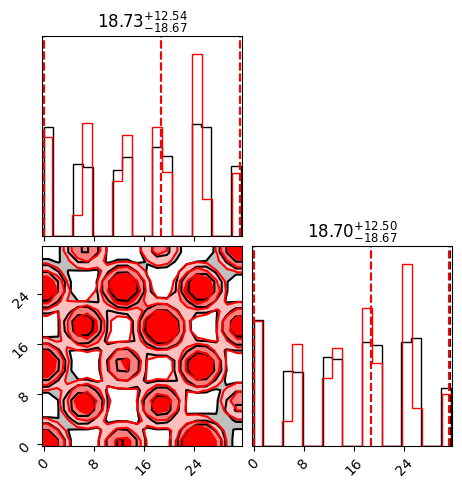

In [5]:
pair_kde = morphZ.PairwiseKDE(samples,'./morphZ_eggbox/params_MI.json',kde_bw=0.01)
pair_samples = pair_kde.resample(2000)
fig = corner.corner(
    posterior_samples[::2,:], bins=20,label_kwargs = {"fontsize": 7},truth_color="dodgerblue",hist_kwargs={"density": True},quantiles=[0.05, 0.5, 0.95],
    show_titles=True,
    fontzise=6,
    title_fmt=".2f",
    plot_datapoints=False,
    fill_contours=True,
    levels=(0.5, 0.8, 0.95),         
    smooth=1.0  
)
corner.corner(
    pair_samples,color="red", bins=20,label_kwargs = {"fontsize": 7},truth_color="dodgerblue",hist_kwargs={"density": True},quantiles=[0.05, 0.5, 0.95],
    show_titles=True,
    fig=fig,
    fontzise=6,
    title_fmt=".2f",
    plot_datapoints=False,
    fill_contours=True,
    levels=(0.5, 0.8, 0.95),         
    smooth=1.0  
)
plt.show()